# 学习
## 制造树

In [1]:
import math
import operator

In [2]:
# Calculate Shannon Entropy
# E = -[pi*log_2`pi
# 计算香农熵
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    
    for featVec in dataSet:
        currentLabel = featVec[-1] #标签存储在最后一列
        if currentLabel not in labelCounts.keys(): #找出不一样的标签并为它创建字典的键
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt = -prob * math.log(prob, 2)
    
    return shannonEnt
            
    
def createDataset():
    data = [[1, 1, 'yes'],
           [1, 1, 'yes'],
           [1, 0, 'no'],
           [0, 1, 'no'],
           [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']

    return data, labels

def splitDataSet(dataset, axis, value):
    data = []
    for feaVec in dataset:
        if feaVec[axis] == value:
            splitFect = feaVec[:axis]
            splitFect.extend(feaVec[axis+1:])
            
            data.append(splitFect)
    return data
            
    
# 选取最好的数据划分方式
def chooseBestFeat(dataset):
    bestFeat = -1 #初始best feature为最后一个
    baseEntropy = calcShannonEnt(dataset)
    bestInfoGain = 0.0
    numFeats = len(dataset[0]) - 1 #bestFeat有初始值了
    
    for i in range(numFeats):
        featList = [item[i] for item in dataset]
        uniqueVals = set(featList)
        newEnt = 0.0
        for value in uniqueVals:
            sub_data = splitDataSet(dataset, i, value)
            prob  = len(sub_data) / float(len(dataset))
            newEnt += prob * calcShannonEnt(sub_data)
            
        InfoGain = baseEntropy - newEnt
#         print('base, in', baseEntropy, InfoGain)
        if (InfoGain > bestInfoGain):
            bestInfoGain = InfoGain
            bestFeat = i
#             print('bestFeat:', bestFeat)
    
    return bestFeat

# 从小到大排序 找到 出现次数最多的类别
def majorityCnt(classList):
    classCount = {} #用字典来存储类别名称
    
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    
    # 字典排序
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    
    return sortedClassCount

def createTree(dataset, labels):
    class_list = [item[-1] for item in dataset]
    if class_list.count(class_list[0]) == len(class_list): #类别完全一样了
        return class_list[0]
    if len(dataset[0]) == 1: #只剩一个特征了
        return majorityCnt[class_list]
    
    bestFeat = chooseBestFeat(dataset)
#     print('bestFeat', bestFeat)
#     print('labels', labels)
    
    bestFeatLabel = labels[bestFeat]
    
    myTree = {bestFeatLabel:{}}
    
    del(labels[bestFeat]) #删掉已经用的fetature
    
    feat_value = [item[bestFeat] for item in dataset]
    uniquefeat = set(feat_value)
    
    for value in uniquefeat:
        subLabel = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataset, bestFeat, value), subLabel)
    
    return myTree
        
    
dataset, labels = createDataset()

myTree = createTree(dataset, labels)




In [3]:
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 画树

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# 定义文本框和箭头格式
decisionNode = dict(boxstyle='sawtooth', fc='0.8')
leafNode = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle='<-')

# 实际绘图：绘制带箭头的注释 
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction', 
                            xytext=centerPt, textcoords='axes fraction',
                           va='center', ha='center', bbox=nodeType, arrowprops=arrow_args)

# 获取叶节点数：决定x轴的长度
def getNumLeafs(myTree):
    numLeafs = 0
    
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == "dict":
            numLeafs += getNumLeafs(secondDict[key]) 
        else: numLeafs += 1
    return numLeafs
    

# 获取树的层数：决定y轴的高度
def getTreeDepth(myTree):
    maxDepth = 0
    
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

# 在父子节点中间位置写文字
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    
    createPlot.ax1.text(xMid, yMid, txtString)

In [6]:
# 画树
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree) #树宽
    depth = getTreeDepth(myTree)   #树深
    
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt) #标记子节点属性值
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD #按比例减少y坐标值
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
    

In [7]:
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white') #创建一个新图形
    fig.clf() #清空绘图区
    
    axprops = dict(xticks=[], yticks=[])
    
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    
    # 绘制两个不同类型的 树节点
#     plotNode('Decision Node', (0.5, 0.1), (0.1,0.5), decisionNode)
#     plotNode('Leaf Node',(0.8,0.1),(0.3,0.8), leafNode)
    
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW;
    plotTree.yOff = 1.0
    
    plotTree(inTree, (0.5, 1.0), '')
    
    plt.show()

In [8]:
# 预先存储一个树信息
def retrieveTree(i):
    listofTree = [{'no surfacing':{0:'no', 1:{'flippers':{0:'no', 1:'yes'}}}},
                  {'no surfacing':{0:'no', 1:{'flippers':{0:{'head':{0:'no', 1:'yes'}}, 1:'no'}}}}]
    return listofTree[i]

In [9]:
myTree = retrieveTree(0)

print('number of leaf nodes: ',getNumLeafs(myTree))

print('number of tree depth: ', getTreeDepth(myTree))
print(myTree)

number of leaf nodes:  3
number of tree depth:  2
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


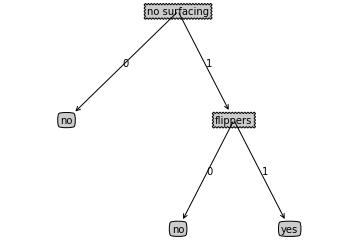

In [10]:
createPlot(myTree)

In [12]:
myTree['no surfacing'][3] = 'maybe'

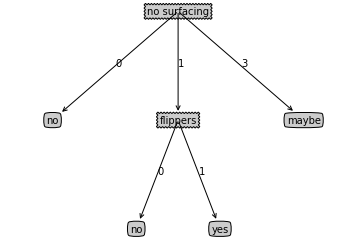

In [13]:
createPlot(myTree)

## Test

In [27]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    print('firstStr: ', firstStr)
    secondTree = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    print('featIndex: ', featIndex)
    
    for key in secondTree.keys():
        print('key: ', key)
        if testVec[featIndex] == key:
            if type(secondTree[key]).__name__ == 'dict': #下面还有分支,递归继续往下
                classLabel = classify(secondTree[key], featLabels, testVec)
            else:
                classLabel = secondTree[key]
    return classLabel

In [16]:
myDat, labels = createDataset()
print(labels)

['no surfacing', 'flippers']


In [17]:
myTree = retrieveTree(0)
print(myTree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


In [29]:
classify(myTree, labels, [1, 1])

firstStr:  no surfacing
featIndex:  0
key:  0
key:  1
firstStr:  flippers
featIndex:  1
key:  0
key:  1


'yes'

## save

In [36]:
def storeTree(inputTree, filename):
    import pickle
    fw = open(filename, 'wb+')
    pickle.dump(inputTree, fw)
    fw.close()

In [39]:
def loadTree(filename):
    import pickle
    fr = open(filename, 'rb+')
    return pickle.load(fr)

In [37]:
storeTree(myTree, 'MLiAc3_lx.txt')

In [40]:
loadTree('MLiAc3_lx.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

# 预测隐形眼镜类型

In [42]:
fr = open('MLiAc3_lenses.txt') 
lenses = [item.strip().split('\t') for item in fr.readlines()]

In [46]:
print(len(lenses))

24


In [47]:
lenses_label = ['age', 'prescript', 'astigmatic', 'tearRate']
                #年龄，            ， 散光，        磨损率

In [49]:
lensesTree = createTree(lenses, lenses_label)
print(lensesTree)

{'tearRate': {'reduced': 'no lenses', 'normal': {'prescript': {'myope': {'astigmatic': {'yes': 'hard', 'no': {'age': {'young': 'soft', 'presbyopic': 'no lenses', 'pre': 'soft'}}}}, 'hyper': {'astigmatic': {'yes': {'age': {'young': 'hard', 'presbyopic': 'no lenses', 'pre': 'no lenses'}}, 'no': 'soft'}}}}}}


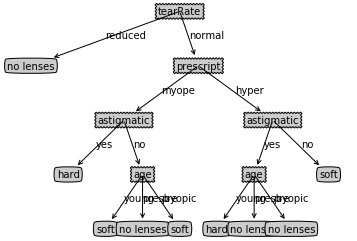

In [50]:
createPlot(lensesTree)